# Introdução a Machine Learning com Data Girls

**Aqui colocaremos em prática os conceitos de Regressão Logística abordados na apresentação teórica.**

**Mãos à obra!** 



## Sobre os dados

O problema está relacionado com características obtidas a partir de imagens digitalizadas de um exame mamário. Foram extraídas 10 características a partir dos núcleos de células de 569 imagens, sendo estas:

* raio (média das distâncias do centro para os pontos no perímetro), 
* textura (desvio padrão dos valores de escala de cinza), 
* perímetro, 
* área, 
* suavidade (variação local em comprimentos de raio), 
* compacidade ($\text{perímetro}^2$ / área - 1), 
* concavidade (gravidade das porções côncavas do contorno), 
* pontos côncavos (número de porções côncavas do contorno),
* simetria,
* dimensão fractal (aproximação costeira - 1).

Três medidas descritivas foram calculadas para os resultados de cada imagem, a média, desvio-padrão e a média dos três maiores valores. Dessa forma, obtemos 30 variáveis preditoras de natureza contínua. A variável resposta é o diagnóstico da paciente referente ao câncer de mama, que pode ser maligno ou benigno. O interesse então é criar um modelo para classificar novas pacientes a partir das variáveis obtidas. 

A descrição do conjunto de dados e outras informações podem ser obtidos em [UCI Machine Learning](http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29)



## Importação

In [1]:
# Importar bibliotecas para uso inicial

# Manipulação dos dados
import pandas as pd
import numpy as np

# Visualização gráfica
import matplotlib.pyplot as plt
import seaborn as sns

# Remover os avisos
import warnings
warnings.filterwarnings('ignore')

**O download do nosso conjunto de dados é realizado através da função abaixo no respectivo link.**

In [28]:
# Importando os dados a serem trabalhados 

dados = pd.read_csv("https://raw.githubusercontent.com/rebecadieb/intro_ML_datagirls/main/data/data.csv")


**Identificar o formato dos dados e a dimensão é fundamental para as próximas etapas.**

In [17]:
# Dimensão da base de dados

dados.shape # (linhas, colunas)

(569, 32)

In [3]:
# Formato dos dados

dados.head() 

# linhas = pacientes 
# colunas = variáveis

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,1.184,2.776,3.001,1.471,2.419,7.871,1.095,9.053,8.589,153.40,6.399,4.904,5.373,1.587,3.003,6.193,25.38,17.33,184.60,2019.0,1.622,6.656,7.119,2.654,4.601,1.189
1,842517,M,20.57,17.77,132.90,1326.0,8.474,7.864,869.000,7.017,1.812,5.667,5.435,7.339,3.398,74.08,5.225,1.308,186.000,134.000,1.389,3.532,24.99,23.41,158.80,1956.0,1.238,1.866,2.416,186.000,275.000,8.902
2,84300903,M,19.69,21.25,130.00,1203.0,1.096,1.599,1.974,1.279,2.069,5.999,7.456,7.869,4.585,94.03,615.000,4.006,3.832,2.058,225.000,4.571,23.57,25.53,152.50,1709.0,1.444,4.245,4.504,243.000,3.613,8.758
3,84348301,M,11.42,20.38,77.58,386.1,1.425,2.839,2.414,1.052,2.597,9.744,4.956,1.156,3.445,27.23,911.000,7.458,5.661,1.867,5.963,9.208,14.91,26.50,98.87,567.7,2.098,8.663,6.869,2.575,6.638,173.000
4,84358402,M,20.29,14.34,135.10,1297.0,1.003,1.328,198.000,1.043,1.809,5.883,7.572,7.813,5.438,94.44,1.149,2.461,5.688,1.885,1.756,5.115,22.54,16.67,152.20,1575.0,1.374,205.000,0.400,1.625,2.364,7.678


**Vamos transformar a variável `id` no índice das linhas**

In [29]:
dados.set_index("id", inplace=True)

**O uso do parâmetro**

```
inplace=True
```
**nos garante que a alteração será feita no conjunto de dados**



In [5]:
dados.head() 

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,1.184,2.776,3.001,1.471,2.419,7.871,1.095,9.053,8.589,153.40,6.399,4.904,5.373,1.587,3.003,6.193,25.38,17.33,184.60,2019.0,1.622,6.656,7.119,2.654,4.601,1.189
842517,M,20.57,17.77,132.90,1326.0,8.474,7.864,869.000,7.017,1.812,5.667,5.435,7.339,3.398,74.08,5.225,1.308,186.000,134.000,1.389,3.532,24.99,23.41,158.80,1956.0,1.238,1.866,2.416,186.000,275.000,8.902
84300903,M,19.69,21.25,130.00,1203.0,1.096,1.599,1.974,1.279,2.069,5.999,7.456,7.869,4.585,94.03,615.000,4.006,3.832,2.058,225.000,4.571,23.57,25.53,152.50,1709.0,1.444,4.245,4.504,243.000,3.613,8.758
84348301,M,11.42,20.38,77.58,386.1,1.425,2.839,2.414,1.052,2.597,9.744,4.956,1.156,3.445,27.23,911.000,7.458,5.661,1.867,5.963,9.208,14.91,26.50,98.87,567.7,2.098,8.663,6.869,2.575,6.638,173.000
84358402,M,20.29,14.34,135.10,1297.0,1.003,1.328,198.000,1.043,1.809,5.883,7.572,7.813,5.438,94.44,1.149,2.461,5.688,1.885,1.756,5.115,22.54,16.67,152.20,1575.0,1.374,205.000,0.400,1.625,2.364,7.678


## Análise exploratória

**Vamos avaliar se existem valores faltantes e/ou linhas duplicadas na base de dados**

### Valores faltantes


In [6]:
# Valores nulos e tipo de variável

dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

**Neste caso não temos valores faltantes no conjunto de dados, pois a quantidade de linhas não nulas pra cada variável é a mesma quantidade de linhas do conjunto de dados.**

**Caso houvessem valores faltantes, estes poderiam ser removidos ou aplicada alguma técnica para substituí-los (imputação de dados). Link para saber mais: [Como lidar com valores faltantes](https://portaldatascience.com/como-lidar-com-valores-faltantes-missing/)**

### Duplicatas


**Verificaremos se as linhas possuem duplicação, de forma que para cada linha do conjunto de dados um valor lógico indicando se ela possui duplicação ou não é associado.**

In [ ]:
dados.duplicated() 

id
842302      False
842517      False
84300903    False
84348301    False
84358402    False
            ...  
926424      False
926682      False
926954      False
927241      False
92751       False
Length: 569, dtype: bool

**Abaixo estamos somando valores lógicos `TRUE` e `FALSE`, equivalente a 1 e 0, respectivamente.**

In [ ]:
dados.duplicated().sum()

0

**Como nosso resultado foi 0, significa que todos os valores foram `FALSE`, sendo assim o conjunto de dados limpo de duplicações.**

### Variável dependente

**Vamos realizar a contagem da variável dependente do nosso problema - `diagnosis` - que trata-se do diagnóstico do câncer de mama das pacientes, podendo ser benigno ou maligno (`B` ou `M`). Caso o diagnóstico seja maligno, é positivo para a doença.**

In [7]:
dados.groupby('diagnosis')['diagnosis'].count()

diagnosis
B    357
M    212
Name: diagnosis, dtype: int64

**Em tarefas de classificação essa etapa é importante para identificar possíveis problemas com desbalanceamento e alternativas para resolvê-los. Link para saber mais: [Como lidar com dados desbalanceados em problemas de classificação](https://medium.com/data-hackers/como-lidar-com-dados-desbalanceados-em-problemas-de-classifica%C3%A7%C3%A3o-17c4d4357ef9)**


**Gráfico de ajuste**

In [8]:
# Codificação da variável binária

from sklearn.preprocessing import LabelEncoder

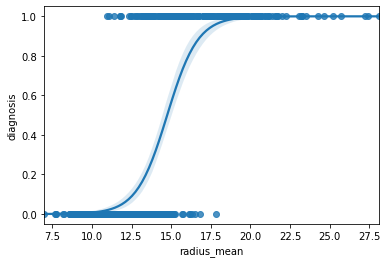

In [50]:
def fitted_plot(data, x, y, logistic, name_fig):
  data["diagnosis"] = LabelEncoder().fit_transform(dados[y])
  fitted = sns.regplot(x=x, y='diagnosis', data = data, logistic=logistic)
  fitted.get_figure().savefig(name_fig)
  return(fitted)

fitted_plot(dados, 'radius_mean', 'diagnosis', True, 'log_test.png')

### Pacote `sweetviz`

**Para analisar as variáveis bem como suas relações, vamos utilizar o pacote `sweetviz` que possui algumas funções capazes de fazer comparações entre conjuntos de dados, ou mesmo comparar grupos, entregando como resultado um documento html completo, com as visualizações gráficas das variáveis.**

In [ ]:
 !pip install sweetviz
 import sweetviz as sv

In [ ]:
#Análise geral

analise = sv.analyze(dados)
analise.show_html("EDA.html")


Report EDA.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
 #Análise por diagnóstico

 compare_diag = sv.compare_intra(dados, dados['diagnosis']=='B',['Benigno','Maligno'])
 compare_diag.show_html('EDA_diagnosis.html')


Report EDA_diagnosis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Modelagem


### Pré-processamento

In [10]:
# Função para dividir os dados em treino e teste
from sklearn.model_selection import train_test_split

# Função para padronizar os dados
from sklearn.preprocessing import StandardScaler

**Decodificar a variável dependente**

In [30]:
# Decodificando para 
# 0 = Benigno
# 1 = maligno

dados["diagnosis"] = LabelEncoder().fit_transform(dados["diagnosis"])

**Dividindo o conjunto de dados em treino e teste**

In [31]:
X = dados.drop(['diagnosis'], axis = 1) # variáveis independentes

In [32]:
y = dados[['diagnosis']]

In [34]:
# O parâmetro random_state é essencial para garantir a reprodutibilidade dos resultados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23102020)

In [35]:
print(y_train.groupby('diagnosis')['diagnosis'].count())
print(X_train.shape)

diagnosis
0    285
1    170
Name: diagnosis, dtype: int64
(455, 30)


**Transformando os dados utilizando a padronização**

In [36]:
std_scale = StandardScaler()
X_train_std = std_scale.fit_transform(X_train)
X_test_std  = std_scale.transform(X_test)

### Regressão logística

In [18]:
# Regressão logística
from sklearn.linear_model import LogisticRegression

**Aplicando o modelo ao conjunto de treino e classificando os dados de teste em benigno ou maligno**

In [37]:
logreg = LogisticRegression()
logreg.fit(X_train_std , y_train)
predictions = logreg.predict(X_test_std)

### Avaliação

In [21]:
# Para visualização dos resultados e cáculo das métricas de desemepenho
from sklearn.metrics import confusion_matrix

**A função abaixo completa foi encontrada em [Visualização da matriz de confusão](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)**

In [38]:
# Função para construir a Matriz de confusão

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

     # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        acuracia  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            sensibilidade = cf[1,1]/sum(cf[1,:])
            especificidade = cf[0,0]/sum(cf[0,:])
            VPP = cf[1,1] / sum(cf[:,1])
            VPN = cf[0,0] / sum(cf[:,0])
            # f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAcurácia={:0.3f}\nSensibilidade={:0.3f}\nEspecificidade={:0.3f}\nVPP={:0.3f}\nVPN={:0.3f}".format(
                acuracia, sensibilidade, especificidade, VPP, VPN)
        else:
            stats_text = "\n\nnAcurácia={:0.3f}".format(acuracia)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Diagnóstico obtido');
        plt.xlabel('Diagnóstico classificado pelo modelo' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

**Verificando os resultados observados e classificados**

In [39]:
# Quantidade pra cada diagnóstico no conjunto de teste
y_test.groupby('diagnosis')['diagnosis'].count()

diagnosis
0    72
1    42
Name: diagnosis, dtype: int64

In [40]:
# Quantidade pra cada diagnóstico classificado pelo modelo
print('0   ', np.count_nonzero(predictions==0))
print('1   ', np.count_nonzero(predictions))

0    75
1    39


In [41]:
cm = confusion_matrix(y_test, predictions); cm

array([[70,  2],
       [ 5, 37]])

**A matriz mostra o resultado observado no conjunto de teste (linha) contra o resultado obtido pela classificação (coluna), como também as métricas necessárias para avaliar o desempenho do modelo**

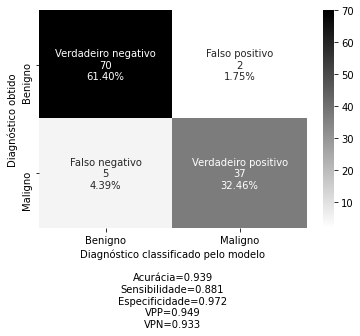

In [42]:
labels = ['Verdadeiro negativo','Falso positivo','Falso negativo', 'Verdadeiro positivo']
diagnosticos = ['Benigno', 'Maligno']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=diagnosticos, 
                      cmap='binary')

### Curva ROC e ponto de corte ótimo

In [43]:
# Curva ROC e AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

**Probabilidades**


In [44]:
pred_prob = logreg.predict_proba(X_test_std)

# Probabilidade do diagnóstico ser maligno
pred_maligno = pred_prob[:,1]

**Encontrando a AUC**

*   TPR = sensibilidade
*   FPR = 1 - especificidade



In [45]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
print("Área abaixo da curva ROC: %f" % roc_auc)

Área abaixo da curva ROC: 0.926587


**Função encontrada em [Roc curve and cut off point](https://www.iditect.com/how-to/53353923.html)**

In [46]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


**Encontrando o ponto de corte ótimo**

Quanto maior o ponto de corte, menor é a sensibilidade e maior a especificidade. O ponto de corte ideal maximiza a sensibilidade e minimiza 1-especificidade.

In [47]:
ponto_corte = Find_Optimal_Cutoff(y_test, pred_maligno); ponto_corte

[0.1968310201921529]

**Classificando a probabilidade em 0 ou 1, baseando-se no ponto de corte encontrado**


In [64]:
pred_otimo = [1 if i > ponto_corte else 0 for i in pred_maligno]

**Conferindo os resultados com a nova classificação**

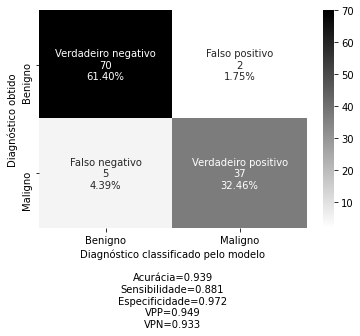

In [65]:
cm_corte = confusion_matrix(y_test, pred_otimo)
labels = ['Verdadeiro negativo','Falso positivo','Falso negativo', 'Verdadeiro positivo']
diagnosticos = ['Benigno', 'Maligno']
make_confusion_matrix(cm_corte, 
                      group_names=labels,
                      categories=diagnosticos, 
                      cmap='binary')

## Dicas de aprofundamento

**Pra quem deseja aprofundar os conhecimentos em *Machine Learning* e/ou melhorar o desempenho do modelo, seguem algumas dicas (alguns tópicos exigem pré-requisitos)**

* Métodos de seleção de variável - 

  *   [Seleção de variável em python](https://medium.com/@alegeorgelustosa/m%C3%A9todos-para-selecionar-as-melhores-vari%C3%A1veis-do-dataset-em-python-2c374b2e9df2)

  *   [Aprenda a selecionar variáveis para o modelo de ML](https://minerandodados.com.br/aprenda-como-selecionar-features-para-seu-modelo-de-machine-learning/) 

* Validação cruzada - [Validação cruzada aprenda de forma simples](https://minerandodados.com.br/validacao-cruzada-aprenda-de-forma-simples-como-usar-essa-tecnica/)

* Outros modelos de classificação - [Types of classification in ML](https://machinelearningmastery.com/types-of-classification-in-machine-learning/)

* Redes neurais - [Build your own neural network for beginners](https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6)

* Otimização do modelo - [Tuning with python step by step](https://towardsdatascience.com/hyperparameter-tuning-with-python-keras-xgboost-guide-7cb3ef480f9c)

* Modelo de regressão - [Regressões em Python](https://imasters.com.br/back-end/data-science-regressoes-com-python)



**[Repositório no github](https://github.com/rebecadieb/intro_ML_datagirls/blob/main/intro_ML.ipynb)**